In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

In [2]:
DEVICE = "cpu"

print(torch.cuda.is_available())
if torch.cuda.is_available():
    DEVICE = "cuda:0"


True


In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
        , transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

train_dataset = torchvision.datasets.CIFAR10(root='./data'
                                             , train=True
                                             , download=True
                                             , transform=transform)
train_loader = DataLoader(train_dataset
                          , batch_size=64
                          , shuffle=True
                          , num_workers=2)
test_dataset = torchvision.datasets.CIFAR10(root='./data'
                                            , train=False
                                            , download=True
                                            , transform=transform)
test_loader = DataLoader(test_dataset
                         , batch_size=64
                         , shuffle=False
                         , num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = train_dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


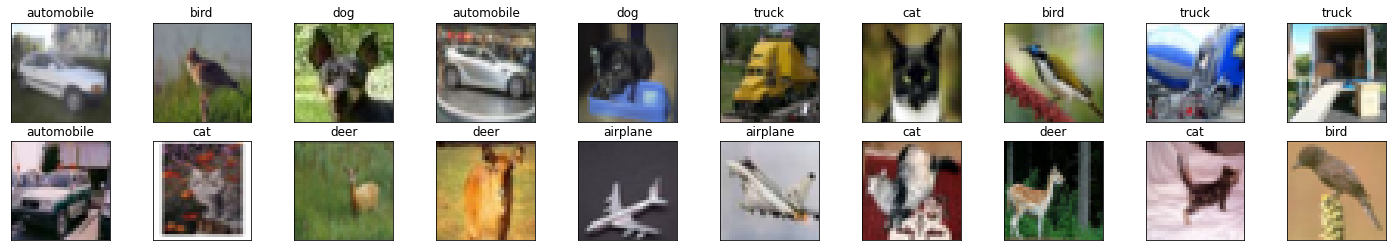

In [6]:
def convert(img):
  img = img.cpu().numpy()
  img = img.transpose(1, 2, 0)
  img = img * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  img = img.clip(0, 1)
  return img

dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=1, padding=1)
            , nn.BatchNorm2d(32)
            , nn.ReLU()
            , nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
            , nn.BatchNorm2d(32)
            , nn.ReLU()
            , nn.MaxPool2d(kernel_size=2, stride=2)
            , nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)
            , nn.BatchNorm2d(64)
            , nn.ReLU()
            , nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=1)
            , nn.BatchNorm2d(64)
            , nn.ReLU()
            , nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            # nn.Dropout(0.5)
             nn.Linear(2304, 64)
            , nn.BatchNorm1d(64)
            , nn.ReLU()
            , nn.Dropout(0.5)
            , nn.Linear(64, 256)
            , nn.BatchNorm1d(256)
            , nn.ReLU()
            , nn.Linear(256, 10) # 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [18]:
net = Net()
net.cuda()
net

Net(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001)
steplr = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [20]:
def train(epoch):
    net.train()
    steplr.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)

        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        out = net(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1)% 100 == 0:
            print(f'Train Epoch: {epoch + 1} --> {(batch_idx + 1) * len(data)}/{len(train_loader.dataset)} '
                  f'({100.0 * (batch_idx + 1) / len(train_loader):.0f}%)\tLoss: {loss.data.item():.6f}')

In [21]:
def evaluate(data_loader: DataLoader):
    net.eval()
    LOSS = 0
    CORRECT = 0

    for data, target in data_loader:
        data, target = Variable(data), Variable(target)

        data = data.cuda()
        target = target.cuda()

        out = net(data)

        LOSS += F.cross_entropy(out, target, size_average=False).data.item()
        pred = out.data.max(1, keepdim=True)[1]
        CORRECT += pred.eq(target.data.view_as(pred)).cpu().sum()

    LOSS /= len(data_loader.dataset)

    print(f'\nLoss: {LOSS:.4f} \t Val Accuracy: {CORRECT}/{len(data_loader.dataset)} '
          f'({100.0 * CORRECT / len(data_loader.dataset):.3f}%)\n')

In [22]:
EPOCHS = 30

for i in range(EPOCHS):
    train(i)
    evaluate(test_loader)

Train Epoch: 1 --> 6400/50000 (13%)	Loss: 1.690735
Train Epoch: 1 --> 12800/50000 (26%)	Loss: 1.585959
Train Epoch: 1 --> 19200/50000 (38%)	Loss: 1.251005
Train Epoch: 1 --> 25600/50000 (51%)	Loss: 1.055244
Train Epoch: 1 --> 32000/50000 (64%)	Loss: 1.088808
Train Epoch: 1 --> 38400/50000 (77%)	Loss: 1.029568
Train Epoch: 1 --> 44800/50000 (90%)	Loss: 1.050050

Loss: 0.8918 	 Val Accuracy: 6879/10000 (68.790%)

Train Epoch: 2 --> 6400/50000 (13%)	Loss: 0.925296
Train Epoch: 2 --> 12800/50000 (26%)	Loss: 0.979385
Train Epoch: 2 --> 19200/50000 (38%)	Loss: 0.998021
Train Epoch: 2 --> 25600/50000 (51%)	Loss: 1.077074
Train Epoch: 2 --> 32000/50000 (64%)	Loss: 1.031958
Train Epoch: 2 --> 38400/50000 (77%)	Loss: 0.834502
Train Epoch: 2 --> 44800/50000 (90%)	Loss: 0.852833

Loss: 0.7825 	 Val Accuracy: 7293/10000 (72.930%)

Train Epoch: 3 --> 6400/50000 (13%)	Loss: 1.319555
Train Epoch: 3 --> 12800/50000 (26%)	Loss: 1.025064
Train Epoch: 3 --> 19200/50000 (38%)	Loss: 0.742737
Train Epoch: 3 

C:\Users\Bill\anaconda3\envs\DeepLearning\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## `Model accuracy --> 83%!`
